<a href="https://colab.research.google.com/github/cpeluso/Bioinformatics-LAB10/blob/main/LAB10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow        as tf
import numpy             as np
import pandas            as pd
import os
import seaborn           as sns
import matplotlib.pyplot as plt

import time

sns.set_theme()

from sklearn.model_selection              import train_test_split
from sklearn.metrics                      import accuracy_score
from sklearn.preprocessing                import MinMaxScaler
from tensorflow.keras                     import layers
from tensorflow.keras.layers.experimental import preprocessing
from google.colab                         import drive, output
from keras                                import backend as K

drive.mount('/content/drive', force_remount = True)
output.clear()

In [3]:
BASE_PATH         = "/content/drive/MyDrive/Datasets/large-multiomic"

METH_FILENAME     = f"{BASE_PATH}/meth.txt"
CLUSTERS_FILENAME = f"{BASE_PATH}/clusters.txt"
MRNA_FILENAME     = f"{BASE_PATH}/mRNA.txt"
PROTEINS_FILENAME = f"{BASE_PATH}/prot.txt"

In [228]:
meth_data, cluster_data, mRNA_data, _ = load_data(METH_FILENAME, CLUSTERS_FILENAME, MRNA_FILENAME, PROTEINS_FILENAME)

cluster_data.cluster = cluster_data.cluster - 1 # [1,2,3,4,5] => [0,1,2,3,4]

'''
Merge mRNA data with cluster data
'''
mRNA_data = mRNA_data.merge(cluster_data, left_index = True, right_index = True)
mRNA_data = normalize_dataframe(mRNA_data)

'''
Merge meth data with cluster data
'''
meth_data = meth_data.merge(cluster_data, left_index = True, right_index = True)
meth_data = normalize_dataframe(meth_data)

'''
Labels inspection
'''
for i in range(5):
  print(f"{len(cluster_data[cluster_data.cluster == i])}\t rows belonging to cluster {i}")

1250	 rows belonging to cluster 0
1000	 rows belonging to cluster 1
1000	 rows belonging to cluster 2
1000	 rows belonging to cluster 3
750	 rows belonging to cluster 4


## Assignment 1: Implement a GAN for sample generation

Download dataset_5000samples.rar from the Teaching Portal. 

After decompressing the file, you will have: mRNA.txt, meth.txt, prot.txt which contain respectively transcriptome, genome and proteome of 5000 samples divided in 5 classes. 

In clusters.txt you can find the label number for each sample. For this assignment you need only the mRNA.txt file.

Implement a GAN for each class in order to generate new samples starting from mRNA.txt file. <br>
Implement an upper sampling technique using SMOTE.<br>
Which are the differences between sample generation using GANs and SMOTE upper sampling?

In [227]:
data = mRNA_data
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,cluster
0,0.333966,0.701087,0.640290,0.554411,0.263794,0.520564,0.633027,0.715708,0.593011,0.770871,0.601214,0.661777,0.743597,0.373324,0.339426,0.518860,0.655779,0.508005,0.724453,0.568271,0.311726,0.668638,0.393210,0.462265,0.717649,0.898011,0.517031,0.652542,0.687342,0.625478,0.409188,0.907177,0.787653,0.666129,0.373977,0.388621,0.304410,0.401956,0.214215,0.251225,...,0.245063,0.398635,0.609120,0.487678,0.241784,0.350986,0.424556,0.339125,0.146922,0.653079,0.627667,0.820508,0.747603,0.723057,0.699102,0.469287,0.562113,0.515307,0.707903,0.675619,0.699560,0.684142,0.294362,0.612973,0.610320,0.270315,0.409818,0.349892,0.314287,0.608358,0.709199,0.611894,0.763897,0.239128,0.795876,0.573995,0.498396,0.621601,0.423564,4
1,0.660550,0.232089,0.163024,0.368027,0.512814,0.413925,0.619938,0.501474,0.388359,0.685889,0.282104,0.217180,0.653216,0.328424,0.263171,0.457918,0.259363,0.641285,0.748272,0.389873,0.787723,0.482979,0.578719,0.456308,0.625706,0.501337,0.343199,0.583325,0.593592,0.584766,0.320873,0.607802,0.697916,0.450335,0.407549,0.753733,0.530084,0.850533,0.260282,0.333913,...,0.309921,0.421868,0.163854,0.348857,0.676055,0.498178,0.809410,0.272555,0.225680,0.548581,0.428224,0.170571,0.351538,0.269103,0.434495,0.594730,0.656786,0.710843,0.697030,0.264503,0.685218,0.429756,0.487203,0.387162,0.660174,0.734660,0.239916,0.284330,0.258149,0.675536,0.503108,0.695346,0.325266,0.274333,0.782965,0.653487,0.474091,0.488940,0.210421,2
2,0.190614,0.704563,0.518615,0.426099,0.717759,0.600128,0.201792,0.582330,0.733987,0.741479,0.558475,0.546625,0.168709,0.784263,0.644294,0.611409,0.280085,0.566964,0.684365,0.715968,0.398558,0.434014,0.711927,0.537393,0.617665,0.386991,0.756917,0.529259,0.539363,0.775787,0.897086,0.374206,0.641379,0.410906,0.572751,0.850527,0.570599,0.696218,0.644826,0.826833,...,0.302387,0.364944,0.758862,0.726495,0.763099,0.473008,0.700586,0.358483,0.686634,0.298796,0.715593,0.280091,0.736409,0.220029,0.456736,0.796928,0.850050,0.244542,0.757874,0.705213,0.732018,0.476759,0.458280,0.493961,0.298475,0.568045,0.340523,0.289717,0.674140,0.483979,0.538242,0.600650,0.320671,0.720311,0.296580,0.280545,0.633265,0.225341,0.608042,3
3,0.789362,0.308383,0.176440,0.452512,0.607311,0.395980,0.583258,0.650997,0.142194,0.689592,0.353632,0.148877,0.757226,0.603736,0.347251,0.369944,0.266391,0.661066,0.688848,0.465430,0.680332,0.641976,0.735272,0.488929,0.644639,0.634820,0.362399,0.362373,0.726775,0.965942,0.345215,0.695377,0.632772,0.441513,0.558312,0.630791,0.604454,0.608835,0.153000,0.275375,...,0.288994,0.647770,0.204964,0.335042,0.801496,0.307066,0.728420,0.296815,0.312305,0.750742,0.512253,0.254139,0.334234,0.369990,0.630193,0.439304,0.606431,0.832753,0.647688,0.269049,0.765771,0.578282,0.570934,0.429984,0.522692,0.767029,0.277008,0.372408,0.343562,0.567464,0.505327,0.484641,0.513227,0.231792,0.583012,0.269958,0.317902,0.497963,0.212104,2
4,0.635404,0.272905,0.329159,0.538752,0.380842,0.421012,0.670941,0.650685,0.353216,0.630704,0.407100,0.325641,0.675232,0.320258,0.333267,0.430529,0.176926,0.743377,0.703511,0.311281,0.687354,0.477146,0.665785,0.482401,0.455719,0.761369,0.400186,0.631210,0.681327,0.553609,0.308028,0.885196,0.747574,0.443305,0.265710,0.650713,0.157942,0.754769,0.330849,0.334131,...,0.259240,0.339164,0.324148,0.460206,0.595811,0.291365,0.860479,0.381568,0.208329,0.796723,0.544736,0.241357,0.178378,0.209853,0.543413,0.706722,0.498724,0.857119,0.592594,0.243212,0.677280,0.570564,0.674788,0.473231,0.723364,0.693811,0.414517,0.301009,0.402043,0.587530,0.599467,0.667786,0.258448,0.297671,0.827771,0.802755,0.430466,0.574227,0.254884,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Basic Neural Network for multi-class classification

#### Data loading

In [ ]:
'''
Divide features from labels
'''
X = data.drop("cluster", axis = 1)
y = data.cluster 

'''
Divide dataset into train and test sets
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

'''
Merge features and labels into train and test sets
'''
train = X_train.merge(y_train, left_index = True, right_index = True).astype(np.float32)
test  = X_test .merge(y_test,  left_index = True, right_index = True).astype(np.float32)

'''
Verify that the split process went well :)
'''
print("# Train dataset #")
for i in range(5):
  print(f"{len(train[train.cluster == i])}\t rows belonging to cluster {i}")
print()
print(f"{len(train)} train examples")

print() 

print("# Test dataset #")
for i in range(5):
  print(f"{len(test[test.cluster == i])}\t rows belonging to cluster {i}")
print()
print(f"{len(test)} test examples")

# Train dataset #
1000	 rows belonging to cluster 0
800	 rows belonging to cluster 1
800	 rows belonging to cluster 2
800	 rows belonging to cluster 3
600	 rows belonging to cluster 4

4000 train examples

# Test dataset #
250	 rows belonging to cluster 0
200	 rows belonging to cluster 1
200	 rows belonging to cluster 2
200	 rows belonging to cluster 3
150	 rows belonging to cluster 4

1000 test examples


In [ ]:
'''
One hot encoding
'''
y_train = tf.keras.utils.to_categorical(train.cluster)
y_test  = tf.keras.utils.to_categorical(test.cluster)

'''
Drop labels from train and test sets
'''
train.drop("cluster", inplace = True, axis = 1)
test .drop("cluster", inplace = True, axis = 1)


'''
Build TensorFlow train and test Datasets
'''
batch_size = 32

train_ds = df_to_ds(train, y_train,                 batch_size = batch_size)
test_ds  = df_to_ds(test,  y_test, shuffle = False, batch_size = batch_size)

#### Classifier

In [ ]:
class NN:

  def __init__(self, features, classes):

    nn_input = tf.keras.layers.Input(shape = (features))
    x = tf.keras.layers.Dropout(0.5)(nn_input)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(classes, activation = "sigmoid")(x)

    self.model = tf.keras.models.Model(nn_input, x)
    self.model.summary()

nn = NN(features = 131, classes = 5).model

nn.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["acc"])

nn.fit(train_ds, epochs = 3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 131)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
125/125 [==============================] - 1s 1ms/step - loss: 1.9006 - acc: 0.3046
Epoch 2/3
125/125 [============

#### Results

In [ ]:
_ = nn.evaluate(test_ds)

32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - acc: 1.0000




---



### TGAN

In [ ]:
class Discriminator:

  def __init__(self, features, verbose = True):
    '''
    The discriminator should ...
    '''

    '''
        discr_input = tf.keras.layers.Input(shape = (features))
        x = tf.keras.layers.Dropout(0.5)(discr_input)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(classes, activation = "sigmoid")(x)

        self.model = tf.keras.models.Model(nn_input, x)
    '''

    discr_input = tf.keras.layers.Input(shape = (features))
    x = tf.keras.layers.Dense(512)(discr_input)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dense(1)(x)

    self.model = tf.keras.models.Model(discr_input, x, name = "Discriminator")

    if verbose == True:
      print(self.model.summary(), end = "\n\n")

  def get_loss(self, real_predictions, fake_predictions):

    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)

    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions),  real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)

    return real_loss + fake_loss

class Generator():

  def __init__(self, noise, features, verbose = True):
    '''
    The generator should ...
    '''

    gen_input = tf.keras.layers.Input(shape = (noise))
    x = tf.keras.layers.Dense(128)(gen_input)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(512, activation = "relu")(x)
    x = tf.keras.layers.Dense(features)(x)

    self.model = tf.keras.models.Model(gen_input, x, name = "Generator")
    
    if verbose == True:
      print(self.model.summary(), end = "\n\n")

  def get_loss(self, fake_predictions):

    fake_predictions = tf.sigmoid(fake_predictions)
    
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions), fake_predictions)

    return fake_loss

class TGAN(tf.keras.Model):

  def __init__(self, ds_features, input_shape_generator, verbose = True):

    super(TGAN, self).__init__()

    self.discriminator = Discriminator(features = ds_features, verbose = verbose)
    self.generator     = Generator    (noise = input_shape_generator, features = ds_features, verbose = verbose)    

    self.disc_optimizer = tf.optimizers.Adam(1e-4)
    self.gen_optimizer  = tf.optimizers.Adam(1e-5)

    self.input_shape_generator = input_shape_generator
    self.verbose = verbose
    pass

  def call(self, N):
    '''
    Generate N records
    '''

    fake_data_noise = np.random.randn(N, self.input_shape_generator).astype("float32")

    generated_data = self.generator.model(fake_data_noise)

    return generated_data
  
  def fit(self, dataset, epochs, verbose = False):
    gen_losses  = []
    disc_losses = []

    for epoch in range(epochs):
      
      if verbose == True:
        print("EPOCH: " + str(epoch))
      
      data_index = 1
      for data in dataset:

        if verbose == True:
          percentage = str(round(data_index * 100 / len(dataset),2)) + "%"
          print(percentage, end=":\n")

        gen_loss, disc_loss = self.train_step(data, verbose)

        data_index += 1

      if self.verbose == True:
        if (epoch + 1) % 50 == 0:
          print()
          print("EPOCH: " + str(epoch + 1))
          print("Generator loss: " + str(gen_loss), end=",\t")
          print("Discriminator loss: " + str(disc_loss))

      gen_losses .append(gen_loss)
      disc_losses.append(disc_loss)

    return gen_losses, disc_losses
        
  def evaluate(self, classifier, test_size, cluster_value):
    generated_data = self.call(test_size)

    predictions = classifier.predict(generated_data)

    predictions = [np.argmax(prediction) for prediction in predictions]
    return predictions.count(cluster_value) / len(predictions)

  def train_step(self, data, verbose):
    fake_data_noise = np.random.randn(data[0].shape[0], self.input_shape_generator).astype("float32")
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_data = self.generator.model(fake_data_noise)
      real_data      = data[0]

      if verbose == True:
        print("1. Generated data")

      real_output = self.discriminator.model(real_data)
      fake_output = self.discriminator.model(generated_data)
      
      if verbose == True:
        print(real_output.shape)
        print(fake_output.shape)

        print("2. Got output from discriminator")

      gen_loss  = self.generator    .get_loss(fake_output)
      
      if verbose == True:
        print("3.a Got loss from generator!")

      disc_loss = self.discriminator.get_loss(real_output, fake_output)

      if verbose == True:
        print("3.b Got loss from discriminator!")

        print("3. Got losses")

      generator_gradients     = gen_tape.gradient (gen_loss,  self.generator    .model.trainable_variables)
      discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.model.trainable_variables)

      if verbose == True:
        print("4. Loaded gradients")

      self.gen_optimizer .apply_gradients(zip(generator_gradients,     self.generator.model.trainable_variables))
      self.disc_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.model.trainable_variables))

      if verbose == True:
        print("5. Applied gradients\n")

        print("Generator loss: " + str(round(np.mean(gen_loss), 2)), end=",\t")
        print("Discriminator loss: " + str(round(np.mean(disc_loss), 2)))

      return np.mean(gen_loss), np.mean(disc_loss)

#### TGAN training

In [ ]:
def train_and_evaluate_tgan(evaluation_classifier, test_size, epochs, batch_size = 32):

  cluster_losses = []

  print("***")
  print("Environment variables:")
  print(f"> Test size = {test_size}")
  print(f"> TGAN training epochs = {epochs}")
  print(f"> Batch size = {batch_size}")
  print("***")

  print()
  print()
  
  for cluster_value in range(len(data.cluster.unique())):
    '''
    Load data of a specific cluster
    '''
    print("###")
    print(f"> Cluster {cluster_value}")
    cluster = load_cluster(cluster_value)
    X = cluster.drop("cluster", axis = 1)
    y = cluster.cluster - (cluster_value - 1) # Ones that correspond - for the classifier - to "real data"

    '''
    Build TensorFlow train and test Datasets
    '''
    train_ds = df_to_ds(X, y, batch_size = batch_size)

    print("> Dataset built.")

    '''
    Train and evaluate TGAN
    '''
    tgan = TGAN(ds_features = 131, input_shape_generator = 32, verbose = False)

    print("> Start training.")

    gen_losses, disc_losses = tgan.fit(train_ds, epochs)

    cluster_losses.append((gen_losses, disc_losses))

    print(f"> Trained TGAN for cluster {cluster_value} data.")
    
    print(f"> Evaluation of {test_size} TGAN generated data on pretrained multi-class classifier:", end = "\t")
    accuracy = tgan.evaluate(classifier = nn, test_size = test_size, cluster_value = cluster_value)
    print(f"Accuracy: {str(accuracy)}")

    print("###", end = "\n\n")
  
  return cluster_losses

### Results

In [ ]:
cluster_losses = train_and_evaluate_tgan(evaluation_classifier = nn, test_size = 100000, epochs = 100, batch_size = 32)

***
Environment variables:
> Test size = 100000
> TGAN training epochs = 100
> Batch size = 32
***


###
> Cluster 0
> Dataset built.
> Start training.
> Trained TGAN for cluster 0 data.
> Evaluation of 100000 TGAN generated data on pretrained multi-class classifier:	Accuracy: 0.99975
###

###
> Cluster 1
> Dataset built.
> Start training.
> Trained TGAN for cluster 1 data.
> Evaluation of 100000 TGAN generated data on pretrained multi-class classifier:	Accuracy: 0.99719
###

###
> Cluster 2
> Dataset built.
> Start training.
> Trained TGAN for cluster 2 data.
> Evaluation of 100000 TGAN generated data on pretrained multi-class classifier:	Accuracy: 0.99805
###

###
> Cluster 3
> Dataset built.
> Start training.
> Trained TGAN for cluster 3 data.
> Evaluation of 100000 TGAN generated data on pretrained multi-class classifier:	Accuracy: 0.9996
###

###
> Cluster 4
> Dataset built.
> Start training.
> Trained TGAN for cluster 4 data.
> Evaluation of 100000 TGAN generated data on pretrain

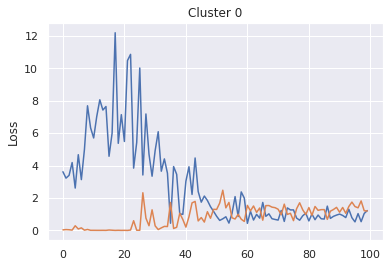

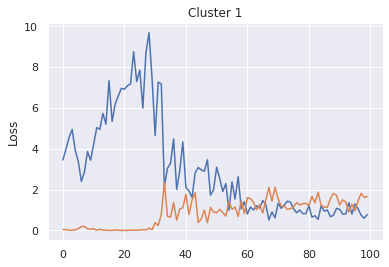

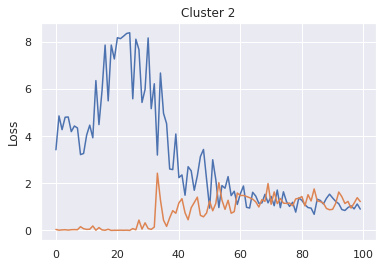

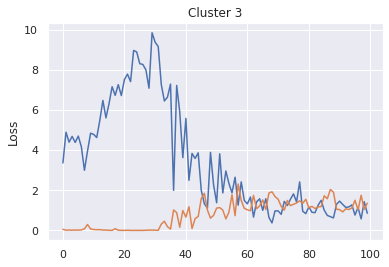

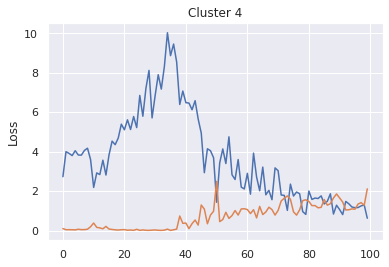

In [ ]:
visualize_tgan_losses(cluster_losses)

## Assignment 2: Implement a Variational Autoencoder for domain translation

Download dataset_5000samples.rar from the Teaching Portal. 

After decompressing the file, you will have: mRNA.txt, meth.txt, prot.txt which contain respectively transcriptome, genome and proteome of 5000 samples divided in 5 classes. 

In clusters.txt you can find the label number for each sample. 

For this assignment you need mRNA.txt and meth.txt files.<br>
* Implement a Variational Autoencoder on mRNA samples
* Implement a Variational Autoencoder on meth samples
* Perform the domain translation using the encoder for mRNA and the decoder for meth samples.
* Compare the new translated samples with the true ones.

### TVAE

In [251]:
class TVAE():

  def __init__(self, features_shape, latent_dim = 2):

    ### Encoder ###

    enc_input = tf.keras.layers.Input(shape = (features_shape))
    x = tf.keras.layers.Dense(512)(enc_input)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(128)(x)
    
    mu    = tf.keras.layers.Dense(latent_dim)(x)
    sigma = tf.keras.layers.Dense(latent_dim)(x)

    dense_shape = K.int_shape(x)

    # Define sampling with reparameterization trick
    def sample_z(args):
      mu, sigma = args
      batch     = K.shape(mu)[0]
      dim       = K.int_shape(mu)[1]
      eps       = K.random_normal(shape=(batch, dim))
      sampled   = mu + K.exp(sigma / 2) * eps
      return sampled

    z = tf.keras.layers.Lambda(sample_z, output_shape=(latent_dim, ))([mu, sigma])

    encoder = tf.keras.models.Model(enc_input, [mu, sigma, z], name = "Encoder")

    ### Decoder ###

    dec_input = tf.keras.layers.Input(shape = (latent_dim, ))
    x = tf.keras.layers.Dense(dense_shape[1])(dec_input)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(512)(x)
    features = tf.keras.layers.Dense(features_shape)(x)

    decoder = tf.keras.models.Model(dec_input, features, name = "Decoder")

    # Instantiate VAE
    vae_outputs = decoder(encoder(enc_input)[2])
    
    self.model = tf.keras.models.Model(enc_input, vae_outputs, name='vae')
    #vae.summary()

#### TVAE training

In [268]:
def train_tvae(epochs, batch_size = 32, datasets = ["mRNA", "meth"]):

  dataset_losses = []
  latent_dim = 2

  print("***")
  print("Environment variables:")
  print(f"> TVAE training epochs = {epochs}")
  print(f"> Batch size = {batch_size}")
  print(f"> Datasets: {datasets}")
  print("***")

  print()
  print()

  for dataset in datasets:
    '''
    Load data of a specific dataset
    '''
    print("###")
    print(f"> {dataset} data.")
    data = load_dataset(dataset) 
    
    X = data.drop("cluster", axis = 1)

    features_shape = len(X.columns)

    '''
    Build TensorFlow train and test Datasets
    '''
    train_ds = df_to_ds(X, labels=None, batch_size = batch_size)

    print("> Dataset built.")

    '''
    Train and evaluate TVAE
    '''
    vae = TVAE(features_shape).model

    vae.compile(optimizer = "adam", loss = tf.keras.losses.kullback_leibler_divergence)

    print("> Start training.")

    history = vae.fit(train_ds, epochs = epochs, batch_size = batch_size, verbose = False)

    dataset_losses.append(history.history['loss'])

    print(f"> Trained TVAE with {dataset} data.")

    '''
    print(f"> Evaluation of {test_size} TGAN generated data on pretrained multi-class classifier:", end = "\t")
    accuracy = tgan.evaluate(classifier = nn, test_size = test_size, cluster_value = cluster_value)
    print(f"Accuracy: {str(accuracy)}")
    '''

    print("###", end = "\n\n")

  return dataset_losses

### Results

In [269]:
dataset_losses = train_tvae(epochs = 100)

***
Environment variables:
> TVAE training epochs = 100
> Batch size = 32
> Datasets: ['mRNA', 'meth']
***


###
> mRNA data.
> Dataset built.
> Start training.
> Trained TVAE with mRNA data.
###

###
> meth data.
> Dataset built.
> Start training.
> Trained TVAE with meth data.
###



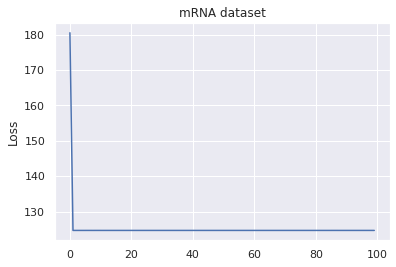

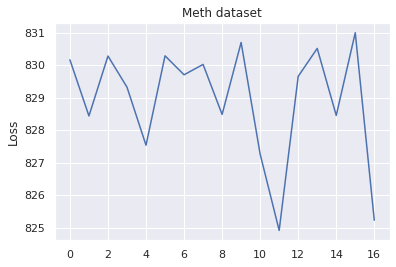

In [270]:
visualize_tvae_losses(dataset_losses)

### Code

In [263]:
def remodel_dataset(df, is_cluster = False):

  if is_cluster == True:

    indexes = df["subjects"]
    new_df  = pd.DataFrame(df["cluster.id"].values, index=indexes, columns = ["cluster"])

  else:

    headers = df.iloc[0]
    headers.name = "subjects"

    indexes = df.index[1:]
    new_df  = pd.DataFrame(df.values[1:], columns=headers, index=indexes)

  return new_df

def load_data(METH_FILENAME, CLUSTERS_FILENAME, MRNA_FILENAME, PROTEINS_FILENAME):
  meth_data     = pd.read_csv(METH_FILENAME,     sep="\t").T
  cluster_data  = pd.read_csv(CLUSTERS_FILENAME, sep="\t")
  mRNA_data     = pd.read_csv(MRNA_FILENAME,     sep="\t").T
  proteins_data = pd.read_csv(PROTEINS_FILENAME, sep="\t").T

  meth_data     = remodel_dataset(meth_data)
  cluster_data  = remodel_dataset(cluster_data, is_cluster = True)
  mRNA_data     = remodel_dataset(mRNA_data)
  proteins_data = remodel_dataset(proteins_data)
  
  return meth_data, cluster_data, mRNA_data, proteins_data

def normalize_dataframe(data):
  labels = data.pop("cluster").values
  new_data = pd.DataFrame(MinMaxScaler().fit_transform(data))
  new_data["cluster"] = labels
  return new_data

def load_cluster(cluster = None):
  if cluster == None:
    print(f"No cluster passed! Choose one cluster between {sorted(data.cluster.unique())} :)")
    return

  return data[data.cluster == cluster] 

def load_dataset(dataset = None):
  if dataset == None:
    print("No dataset requested! Choose one dataset between \"meth\" and \"mRNA\"")

  if dataset == "meth":
    return meth_data

  if dataset == "mRNA":
    return mRNA_data

  raise Exception('No dataset retrieved! Check your parameters!')


def df_to_ds(dataframe, labels, shuffle=True, batch_size=32):
  # A utility method to create a tf.data dataset from a Pandas Dataframe

  if labels == None:

    dataframe = dataframe.copy()

    ds = tf.data.Dataset.from_tensor_slices((dataframe, dataframe))
    
    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
  
  else:

    dataframe = dataframe.copy()

    ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
    
    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def visualize_tgan_losses(cluster_losses):
  '''
  Extract loss-data from history of TGAN fit
  '''

  cluster0_gen_losses  = cluster_losses[0][0]
  cluster0_disc_losses = cluster_losses[0][1]

  cluster1_gen_losses  = cluster_losses[1][0]
  cluster1_disc_losses = cluster_losses[1][1]

  cluster2_gen_losses  = cluster_losses[2][0]
  cluster2_disc_losses = cluster_losses[2][1]

  cluster3_gen_losses  = cluster_losses[3][0]
  cluster3_disc_losses = cluster_losses[3][1]

  cluster4_gen_losses  = cluster_losses[4][0]
  cluster4_disc_losses = cluster_losses[4][1]

  '''
  Visualize loss-data
  '''
  cluster0_gen_losses  = pd.DataFrame(cluster0_gen_losses,  columns = ["Loss"])
  cluster0_disc_losses = pd.DataFrame(cluster0_disc_losses, columns = ["Loss"])

  sns.lineplot(
        data=cluster0_gen_losses, 
        x=cluster0_gen_losses.index, y="Loss", 
    ).set_title("Cluster 0")

  sns.lineplot(
        data=cluster0_disc_losses, 
        x=cluster0_disc_losses.index, y="Loss", 
    ).set_title("Cluster 0")

  plt.show()

  cluster1_gen_losses  = pd.DataFrame(cluster1_gen_losses,  columns = ["Loss"])
  cluster1_disc_losses = pd.DataFrame(cluster1_disc_losses, columns = ["Loss"])

  sns.lineplot(
        data=cluster1_gen_losses, 
        x=cluster1_gen_losses.index, y="Loss", 
    ).set_title("Cluster 1")

  sns.lineplot(
        data=cluster1_disc_losses, 
        x=cluster1_disc_losses.index, y="Loss", 
    ).set_title("Cluster 1")

  plt.show()

  cluster2_gen_losses  = pd.DataFrame(cluster2_gen_losses,  columns = ["Loss"])
  cluster2_disc_losses = pd.DataFrame(cluster2_disc_losses, columns = ["Loss"])

  sns.lineplot(
        data=cluster2_gen_losses, 
        x=cluster2_gen_losses.index, y="Loss", 
    ).set_title("Cluster 2")

  sns.lineplot(
        data=cluster2_disc_losses, 
        x=cluster2_disc_losses.index, y="Loss", 
    ).set_title("Cluster 2")

  plt.show()

  cluster3_gen_losses  = pd.DataFrame(cluster3_gen_losses,  columns = ["Loss"])
  cluster3_disc_losses = pd.DataFrame(cluster3_disc_losses, columns = ["Loss"])

  sns.lineplot(
        data=cluster3_gen_losses, 
        x=cluster3_gen_losses.index, y="Loss", 
    ).set_title("Cluster 3")

  sns.lineplot(
        data=cluster3_disc_losses, 
        x=cluster3_disc_losses.index, y="Loss", 
    ).set_title("Cluster 3")

  plt.show()

  cluster4_gen_losses  = pd.DataFrame(cluster4_gen_losses,  columns = ["Loss"])
  cluster4_disc_losses = pd.DataFrame(cluster4_disc_losses, columns = ["Loss"])

  sns.lineplot(
        data=cluster4_gen_losses, 
        x=cluster4_gen_losses.index, y="Loss", 
    ).set_title("Cluster 4")

  sns.lineplot(
        data=cluster4_disc_losses, 
        x=cluster4_disc_losses.index, y="Loss", 
    ).set_title("Cluster 4")

  plt.show()

def visualize_tvae_losses(dataset_losses):
  '''
  Extract loss-data from history of TVAE fit
  '''

  mRNA_losses = dataset_losses[0]

  meth_losses = dataset_losses[1]

  '''
  Visualize loss-data
  '''
  mRNA_losses = pd.DataFrame(mRNA_losses,  columns = ["Loss"])

  sns.lineplot(
        data=mRNA_losses, 
        x=mRNA_losses.index, y="Loss", 
    ).set_title("mRNA dataset")

  plt.show()

  meth_losses = pd.DataFrame(meth_losses, columns = ["Loss"])

  sns.lineplot(
        data=meth_losses, 
        x=meth_losses.index, y="Loss", 
    ).set_title("Meth dataset")

  plt.show()